In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tqdm
import sklearn
import skimage.feature
import os, sys
sys.path.append("../")
import savewally
from PIL import Image

# Load training images

In [21]:
fp_pos = "../data/patches/StitchMICE_ORKlh16_3_1104_CP_FINAL.tif/positive/"
fp_neg = "../data/patches/StitchMICE_ORKlh16_3_1104_CP_FINAL.tif/negative/"

In [22]:
def read_patches(fp):
    patches = []
    for patch in tqdm.tqdm(os.listdir(fp)):
        patch = plt.imread(fp + patch)
        patches.append(patch)
    return np.array(patches)

In [23]:
positive_patches = read_patches(fp_pos)
negative_patches = read_patches(fp_neg)

100%|███████████████████████████████████████████████████████████████████████| 24000/24000 [00:07<00:00, 3096.64it/s]


# Feature engineering

In [24]:
from itertools import chain
patches = np.array([skimage.feature.hog(savewally.RGB2Lum(im)) 
                    for im in chain(positive_patches, 
                                    negative_patches)])

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [25]:
patches_bool = np.zeros(patches.shape[0])
patches_bool[:positive_patches.shape[0]] = 1

## Train-test split

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches,
                                                    patches_bool, random_state=0)

print(X_train.shape, X_test.shape)

(20280, 1296) (6761, 1296)


# Training a SVM

In [27]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.9879684418145956

In [28]:
grid.best_params_

{'C': 8.0}

In [29]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=8.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [30]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      6011
         1.0       0.97      0.92      0.94       750

   micro avg       0.99      0.99      0.99      6761
   macro avg       0.98      0.96      0.97      6761
weighted avg       0.99      0.99      0.99      6761



In [31]:
def plot_slider_prediction(test_image, clf):
    indices, patches = zip(*sliding_window(np.asarray(test_image)))
    
    hogs = []
    for patch in patches:
        greyscale = savewally.RGB2Lum(patch)
        hog_vec = skimage.feature.hog(greyscale, visualize=False)
        hogs.append(hog_vec)
    hogs = np.array(hogs)
    labels = clf.predict(hogs)
    
    Ni, Nj = (40,40)
    indices = np.array(indices)

    fig, ax = plt.subplots(figsize=(20,15))
    ax.imshow(np.asarray(test_image), cmap='gray')
    ax.axis('off')

    for i, j in indices[labels == 1]:
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='yellow',
                                   alpha=0.3, lw=2, facecolor='none'))
        
    return ax


def sliding_window(img, istep=10, jstep=10, scale=1., patch_size=(50,50)):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


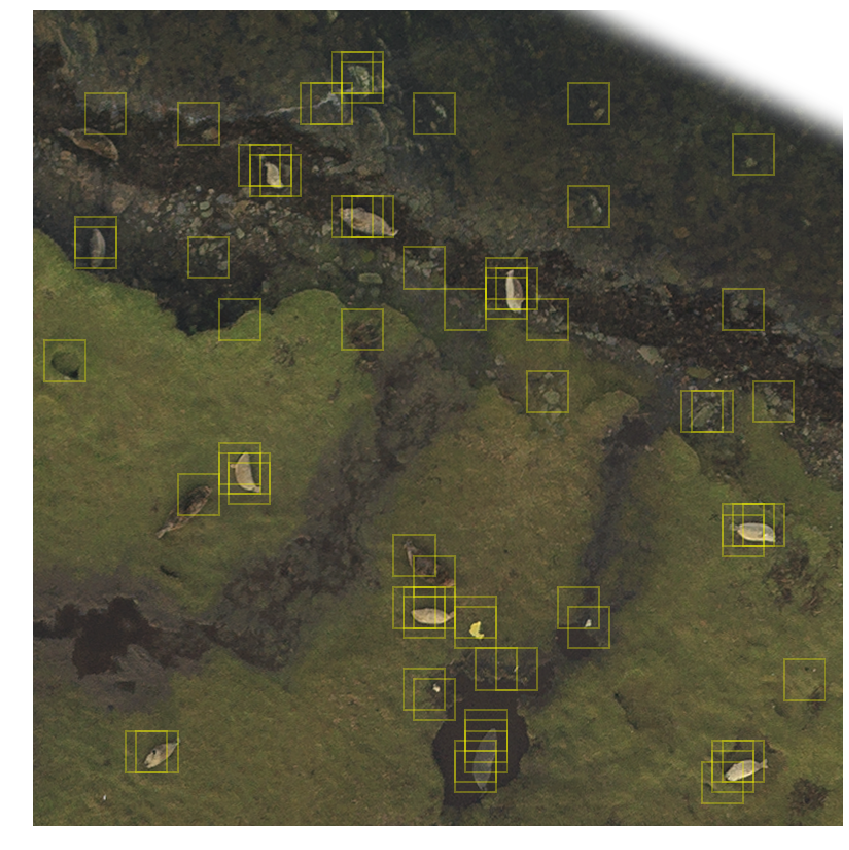

In [32]:
plot_slider_prediction(Image.open("../images/test_image2.png"), model)